## CNN_LSTM Base
- to capture spatial (CNN) -temporal (LSTM) information
- often used in NEXT FRAME VIDEO PREDICTION problem in vision


### Sources

https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9063513

https://keras.io/examples/vision/conv_lstm/

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-01-16 10:14:25.715298: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Reading Data
dir_name="../data/data1"
val_dir_name="../data/data2"

sys.path.insert(0, '../src/preprocess')

from data_preprocess import preprocess_images_nfp

data,pco2 = preprocess_images_nfp(dir_name)


/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

# gives you gradient exploding problem
# X=data[X_index][:-1]
y=np.expand_dims(pco2[X_index][1:],axis=4)
X=data[X_index][:-1]
#y=data[X_index][1:][:,:,:,:,5]
print(X.shape, y.shape)

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)


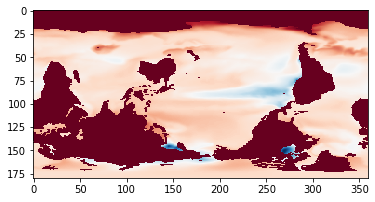

In [4]:
plt.imshow(y[0][0],cmap="RdBu", interpolation="nearest")

In [5]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=y[0].shape

INPUT_SHAPE

(3, 180, 360, 6)

In [6]:
tf.keras.backend.clear_session()

In [6]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial

DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)



model = keras.models.Sequential([
    DefaultConvLSTM2D(input_shape=INPUT_SHAPE),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(3,3)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(1,1)),
    keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),activation="elu", padding="same")
    
])


model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(),
)

2022-01-16 09:53:20.472583: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-16 09:53:20.499784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-16 09:53:20.559085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-01-16 09:53:20.559129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-16 09:53:21.618586: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-16 09:53:21.618646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-0

In [8]:
model.summary()

NameError: name 'model' is not defined

In [7]:
model_path="../models/base_CNN_LSTM.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 20
batch_size = 8

# Fit the model to the training data.
model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X, y),
    callbacks=callbacks,
)

NameError: name 'model' is not defined

In [8]:

best_model = tf.keras.models.load_model('../models/base_CNN_LSTM.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_frames=best_model.predict(X,verbose=1)

2022-01-16 10:14:58.497715: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-16 10:14:58.530974: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-16 10:14:58.591485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-01-16 10:14:58.591700: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-16 10:14:58.643956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-16 10:14:58.644015: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-0

14/14 [==============================] - 28s 713ms/step


In [9]:
predicted_frames[y==0]=0.0

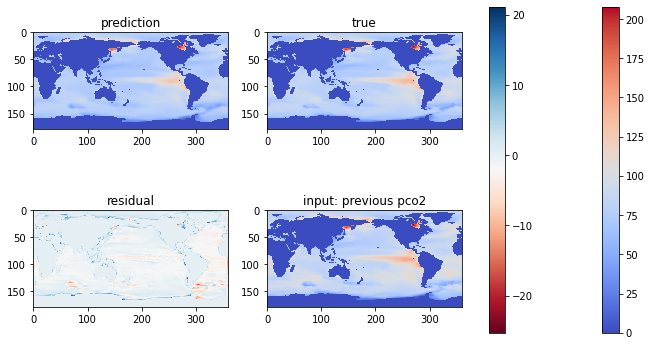

In [12]:
figure, axis = plt.subplots(2, 2,figsize=(12, 6))


img=axis[0][0].imshow(np.flipud(predicted_frames[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_frames[0][1]-y[0][1]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest")
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(X[0][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("input: previous pco2")

plt.savefig('../assets/next-frame-prediction.png')

plt.show()




In [88]:
# RMSE of pco2
np.sqrt(np.mean((predicted_frames-y)**2))

2.9300797449898

### Creating Gifs

In [10]:
import imageio

filenames = []

for i in range(418):
    # plot the line chart
    figure, axis = plt.subplots(2, 2,figsize=(12, 6))

    img=axis[0][0].imshow(np.flipud(predicted_frames[i][1]),cmap="coolwarm", interpolation="nearest")
    axis[0][0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[0][1].imshow(np.flipud(y[i][1]),cmap="coolwarm", interpolation="nearest")
    axis[0][1].set_title("true")

    diff=np.flipud(np.squeeze(predicted_frames[i][1]-y[i][1]))
    img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest")
    axis[1][0].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    img2=axis[1][1].imshow(np.flipud(X[i][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
    axis[1][1].set_title("input: previous pco2")
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


with imageio.get_writer('../assets/cnn-lstm.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)


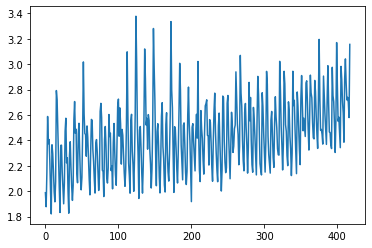

In [18]:
rmses = []

for i in range(418):    
    rmse = np.sqrt(np.mean((predicted_frames[i][1]-y[i][1])**2))
    rmses.append(rmse)
    
plt.plot(rmses)
plt.savefig('../assets/nfp-overtime.png')

## Getting PCO2 Prediction per Point

In [11]:
def inverse_scale_image_nfp(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [12]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2 = read_xarray(dir_name)
y_true,y_pred=inverse_scale_image_nfp(predicted_frames,pco2.pCO2.data)  

In [33]:
print("Scaled back RMSE score:")
np.sqrt(np.mean((y_true[:,:1]-y_pred[:,:1])**2))

Scaled back RMSE score:


6.307770392925103